In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc

LSH (Locality-Sensitive Hashing ) KNN

In [115]:
import numpy as np
import matplotlib.pyplot as plt

class LSH:
    def __init__(self, data, num_bits=10):
        self.num_bits = num_bits
        self.data = data
        self.R = np.random.randn(data.shape[1] + 1, num_bits) # Hyperplanes
        self.buckets = {i: [] for i in range(2**num_bits)}
        self.R[:,num_bits-1]=1
        self.data_aug=np.hstack([np.ones((data.shape[0],1)),data])

        for index, point in enumerate(self.data_aug):
            hash_value = self.calculate_hash_value(point)
            self.buckets[hash_value].append(index)
        
    def calculate_hash_value(self, point):
        boolean_values = (point @ self.R > 0).astype(int)
        hash_value = sum([boolean_values[i] << i for i in range(self.num_bits)])
        return hash_value
    
    def query(self, point, k=1):
        point_aug = np.append([1], point)
        hash_value = self.calculate_hash_value(point_aug)
        bucket_indices = self.buckets[hash_value]
        bucket_data = self.data[bucket_indices]
        distances = np.linalg.norm(bucket_data - point, axis=1)
        nearest_k_indices = np.argsort(distances)[:k]
        nearest_k_data_indices = [bucket_indices[i] for i in nearest_k_indices]
        
        return nearest_k_data_indices

    def plot_partitions(self):
        for i in range(self.num_bits):
            x1 = np.array([min(self.data[:, 0]), max(self.data[:, 0])])
            x2 = (-self.R[0, i] - self.R[1, i] * x1) / self.R[2, i]
            plt.plot(x1, x2)

        plt.scatter(self.data[:, 0], self.data[:, 1], label='Data Points')
        plt.xlabel('X')
        plt.ylabel('Y')
        # plt.xlim(min(self.data[:, 0]), max(self.data[:, 0]))
        # plt.ylim(min(self.data[:, 1]), max(self.data[:, 1]))
        plt.title('LSH Partitions')
        plt.legend()
        plt.show()

# # Example usage:
# # Assuming you have already created the LSH object 'lsh' with the dataset 'data'
# import numpy as np

# # Generate random 2D data
# np.random.seed(0)
# data = np.random.rand(100, 2)  # 100 data points in 2 dimensions

# # Example usage:
# lsh = LSH(data, num_bits=4)
# lsh.plot_partitions()


KD-Tree

In [116]:
class KDTreeNode:
    def __init__(self, point, split_axis, left=None, right=None):
        self.point = point
        self.split_axis = split_axis
        self.left_child = left
        self.right_child = right

class KDTree:
    def __init__(self, data):
        self.data = data
        self.root = self.build_tree(data, 0)

    def build_tree(self, data, depth):
        if not data.any():
            return None

        current_axis = depth % data.shape[1]
        sorted_data = data[data[:, current_axis].argsort()]
        median_index = len(data) // 2

        return KDTreeNode(
            sorted_data[median_index],
            current_axis,
            left=self.build_tree(sorted_data[:median_index], depth + 1),
            right=self.build_tree(sorted_data[median_index + 1:], depth + 1),
        )

    def find_nearest_neighbors(self, node, query_point, k, priority_queue):
        if node is None:
            return

        split_axis = node.split_axis
        distance_to_node = np.sqrt(np.sum((query_point-node.point)**2))

        if len(priority_queue) < k:
            priority_queue.append((distance_to_node, node.point))

        elif distance_to_node < priority_queue[-1][0]:
            priority_queue[-1] = (distance_to_node, node.point)
            priority_queue.sort(key=lambda x: x[0])

        if query_point[split_axis] < node.point[split_axis]:
            self.find_nearest_neighbors(node.left_child, query_point, k, priority_queue)

            if len(priority_queue) < k or abs(query_point[split_axis] - node.point[split_axis]) < priority_queue[-1][0]:
                self.find_nearest_neighbors(node.right_child, query_point, k, priority_queue)

        else:
            self.find_nearest_neighbors(node.right_child, query_point, k, priority_queue)

            if len(priority_queue) < k or abs(query_point[split_axis] - node.point[split_axis]) < priority_queue[-1][0]:
                self.find_nearest_neighbors(node.left_child, query_point, k, priority_queue)

    def query(self, query_point, k=1):
        priority_queue = []
        self.find_nearest_neighbors(self.root, query_point, k, priority_queue)

        indices = [np.where((self.data == x[1]).all(axis=1))[0][0] for x in priority_queue]
        return indices


Naive KNN

In [117]:
# class NaiveKNN:
#     def __init__(self, k):
#         self.k = k

#     def fit(self, X_train, y_train):
#         self.X_train = X_train
#         self.y_train = y_train
        
#     def predict(self, query):
#         distances = []
#         for x_train in self.X_train:
#             distance = np.linalg.norm(query - x_train)
#             distances.append(distance)
#         np.argsort(distances)
#         neighbors = distances[:self.k]
#         labels = [neighbor[1] for neighbor in neighbors]
#         prediction = max(set(labels), key=labels.count)
#         neighbors = np.array(neighbors)
#         return (neighbors,prediction)

In [118]:
class NaiveKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, query):
        distance = [np.sqrt(np.sum((x_train-query)**2)) for x_train in self.X_train]
        distance = np.argsort(distance)
        nearest_indices = distance[:self.k]
        prediction = np.mean(self.y_train[nearest_indices])
        return (nearest_indices, prediction)

In [119]:
def generate_dataset(N, D):
    return np.random.rand(N, D)

Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory comparison for finding $K$ nearest neighbours. 

In [167]:
def plot_metrics_D(N, dimensions, k, xlabel):
    
        lsh_tr_times, lsh_tr_memories = [], []
        kdtree_tr_times, kdtree_tr_memories = [], []
        naive_tr_times, naive_tr_memories = [], []

        lsh_te_times, lsh_te_memories = [], []
        kdtree_te_times, kdtree_te_memories = [], []
        naive_te_times, naive_te_memories = [], []

        for D in dimensions:    
            dataset = generate_dataset(N, D)
            y = np.random.randint(2, size = N)
            query_point_index=np.random.randint(N)

            # Training phase for LSH KNN
            tracemalloc.start()
            start_time = time.time()
            lsh = LSH(dataset)
            training_time_lsh = time.time() - start_time
            _, peak_memory_lsh = tracemalloc.get_traced_memory()
            training_memory_lsh = peak_memory_lsh / 1024  # Convert to KB
            tracemalloc.stop()
            lsh_tr_times.append(training_time_lsh)
            lsh_tr_memories.append(training_memory_lsh)

            # Testing phase for LSH KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            lsh.query(query_point, k)
            testing_time_lsh = time.time() - start_time
            _, peak_memory_lsh1 = tracemalloc.get_traced_memory()
            testing_memory_lsh = peak_memory_lsh1 / 1024  # Convert to KB
            tracemalloc.stop()
            lsh_te_times.append(testing_time_lsh)
            lsh_te_memories.append(testing_memory_lsh)

            # Training phase for KDTree KNN
            tracemalloc.start()
            start_time = time.time()
            kdtree = KDTree(dataset)
            training_time_kd = time.time() - start_time
            _, peak_memory_kd = tracemalloc.get_traced_memory()
            training_memory_kd = peak_memory_kd / 1024  # Convert to KB
            tracemalloc.stop()
            kdtree_tr_times.append(training_time_kd)
            kdtree_tr_memories.append(training_memory_kd)

            # Testing phase for KDTree KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            kdtree.query(query_point, k)
            testing_time_kd = time.time() - start_time
            _, peak_memory_kd1 = tracemalloc.get_traced_memory()
            testing_memory_kd = peak_memory_kd1 / 1024  # Convert to KB
            tracemalloc.stop()
            kdtree_te_times.append(testing_time_kd)
            kdtree_te_memories.append(testing_memory_kd)

            # training for naive KNN = memorising data
            tracemalloc.start()
            naive_knn = NaiveKNN(k)
            start_time = time.time()
            naive_knn.fit(dataset,y)
            training_time_naive = time.time() - start_time
            _, peak_memory_naive = tracemalloc.get_traced_memory()
            training_memory_naive = peak_memory_naive / 1024  # Convert to KB
            tracemalloc.stop()
            naive_tr_times.append(training_time_naive)
            naive_tr_memories.append(training_memory_naive)

            # Testing phase for naive KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            naive_knn.predict(query_point)
            testing_time_naive = time.time() - start_time
            _, peak_memory_naive = tracemalloc.get_traced_memory()
            testing_memory_naive = peak_memory_naive / 1024  # Convert to KB
            tracemalloc.stop()
            naive_te_times.append(testing_time_naive)
            naive_te_memories.append(testing_memory_naive)

        fig, axs = plt.subplots(1, 4, figsize=(16, 4),squeeze=False)

        # Plot training time comparison
        # print(len(dimensions), len(lsh_tr_times))
        axs[0, 0].plot(dimensions, lsh_tr_times, label="LSH KNN")
        axs[0, 0].plot(dimensions, kdtree_tr_times, label="KD-tree KNN")
        axs[0, 0].plot(dimensions, naive_tr_times, label="Naive KNN")
        axs[0, 0].set_xlabel(f"{xlabel}")
        axs[0, 0].set_ylabel("Time (s)")
        axs[0, 0].set_title("Training Time Comparison")
        axs[0, 0].legend()

        # Plot memory usage comparison during training time
        axs[0, 1].plot(dimensions, lsh_tr_memories, label="LSH KNN")
        axs[0, 1].plot(dimensions, kdtree_tr_memories, label="KD-tree KNN")
        axs[0, 1].plot(dimensions, naive_tr_memories, label="Naive KNN")
        axs[0, 1].set_xlabel(f"{xlabel}")
        axs[0, 1].set_ylabel("Memory (KB)")
        axs[0, 1].set_title("Memory Usage Comparison during Training Time")
        axs[0, 1].legend()

        # Plot testing time comparison
        axs[0, 2].plot(dimensions, lsh_te_times, label="LSH KNN")
        axs[0, 2].plot(dimensions, kdtree_te_times, label="KD-tree KNN")
        axs[0, 2].plot(dimensions, naive_te_times, label="Naive KNN")
        axs[0, 2].set_xlabel(f"{xlabel}")
        axs[0, 2].set_ylabel("Time (s)")
        axs[0, 2].set_title("Testing Time Comparison")
        axs[0, 2].legend()

        # Plot memory usage comparison during testing time
        axs[0, 3].plot(dimensions, lsh_te_memories, label="LSH KNN")
        axs[0, 3].plot(dimensions, kdtree_te_memories, label="KD-tree KNN")
        axs[0, 3].plot(dimensions, naive_te_memories, label="Naive KNN")
        axs[0, 3].set_xlabel(f"{xlabel}")
        axs[0, 3].set_ylabel("Memory (KB)")
        axs[0, 3].set_title("Memory Usage Comparison during Testing Time")
        axs[0, 3].legend()

        #plt.suptitle(f"Comparison of KNN Methods for N = {N}", fontsize=16)
        plt.tight_layout() 
        plt.show()


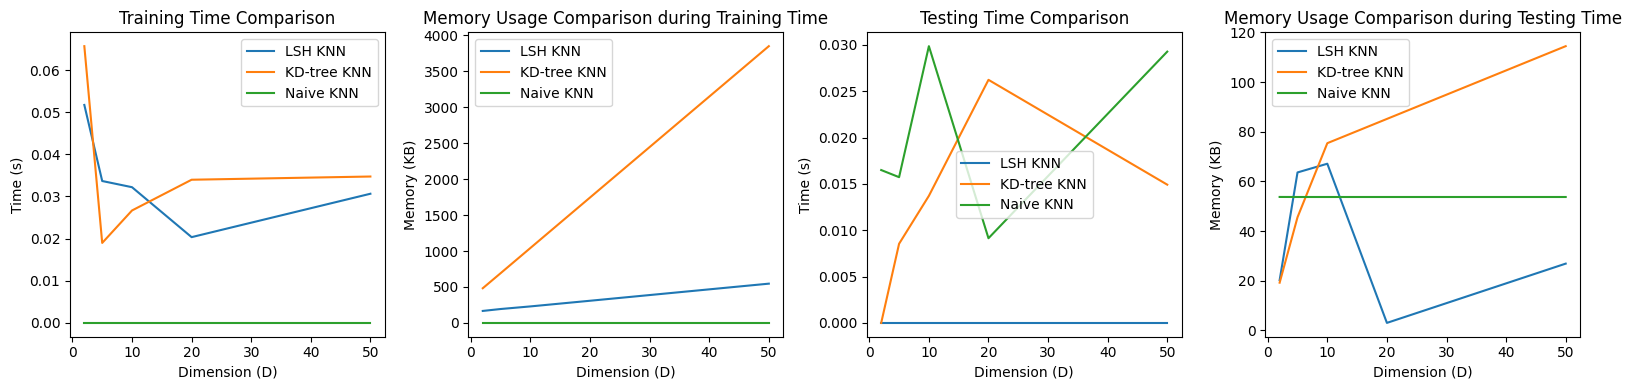

In [171]:
dataset_sizes=1000
k=5
dimensions = [2, 5, 10, 20, 50]
plot_metrics_D(dataset_sizes, dimensions, k, xlabel="Dimension (D)")

In [165]:
def plot_metrics_N(dataset_sizes, D, k, xlabel):
    
        lsh_tr_times, lsh_tr_memories = [], []
        kdtree_tr_times, kdtree_tr_memories = [], []
        naive_tr_times, naive_tr_memories = [], []

        lsh_te_times, lsh_te_memories = [], []
        kdtree_te_times, kdtree_te_memories = [], []
        naive_te_times, naive_te_memories = [], []

        for N in dataset_sizes:    
            dataset = generate_dataset(N, D)
            y = np.random.randint(2, size = N)
            query_point_index=np.random.randint(N)

            # Training phase for LSH KNN
            tracemalloc.start()
            start_time = time.time()
            lsh = LSH(dataset)
            training_time_lsh = time.time() - start_time
            _, peak_memory_lsh = tracemalloc.get_traced_memory()
            training_memory_lsh = peak_memory_lsh / 1024  # Convert to KB
            tracemalloc.stop()
            lsh_tr_times.append(training_time_lsh)
            lsh_tr_memories.append(training_memory_lsh)

            # Testing phase for LSH KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            lsh.query(query_point, k)
            testing_time_lsh = time.time() - start_time
            _, peak_memory_lsh1 = tracemalloc.get_traced_memory()
            testing_memory_lsh = peak_memory_lsh1 / 1024  # Convert to KB
            tracemalloc.stop()
            lsh_te_times.append(testing_time_lsh)
            lsh_te_memories.append(testing_memory_lsh)

            # Training phase for KDTree KNN
            tracemalloc.start()
            start_time = time.time()
            kdtree = KDTree(dataset)
            training_time_kd = time.time() - start_time
            _, peak_memory_kd = tracemalloc.get_traced_memory()
            training_memory_kd = peak_memory_kd / 1024  # Convert to KB
            tracemalloc.stop()
            kdtree_tr_times.append(training_time_kd)
            kdtree_tr_memories.append(training_memory_kd)

            # Testing phase for KDTree KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            kdtree.query(query_point, k)
            testing_time_kd = time.time() - start_time
            _, peak_memory_kd1 = tracemalloc.get_traced_memory()
            testing_memory_kd = peak_memory_kd1 / 1024  # Convert to KB
            tracemalloc.stop()
            kdtree_te_times.append(testing_time_kd)
            kdtree_te_memories.append(testing_memory_kd)

            # training for naive KNN = memorising data
            tracemalloc.start()
            naive_knn = NaiveKNN(k)
            start_time = time.time()
            naive_knn.fit(dataset,y)
            training_time_naive = time.time() - start_time
            _, peak_memory_naive = tracemalloc.get_traced_memory()
            training_memory_naive = peak_memory_naive / 1024  # Convert to KB
            tracemalloc.stop()
            naive_tr_times.append(training_time_naive)
            naive_tr_memories.append(training_memory_naive)

            # Testing phase for naive KNN
            tracemalloc.start()
            start_time = time.time()
            query_point = dataset[query_point_index]
            naive_knn.predict(query_point)
            testing_time_naive = time.time() - start_time
            _, peak_memory_naive = tracemalloc.get_traced_memory()
            testing_memory_naive = peak_memory_naive / 1024  # Convert to KB
            tracemalloc.stop()
            naive_te_times.append(testing_time_naive)
            naive_te_memories.append(testing_memory_naive)

        fig, axs = plt.subplots(1, 4, figsize=(16, 4),squeeze=False)

        # Plot training time comparison
        # print(len(dimensions), len(lsh_tr_times))
        axs[0, 0].plot(dataset_sizes, lsh_tr_times, label="LSH KNN")
        axs[0, 0].plot(dataset_sizes, kdtree_tr_times, label="KD-tree KNN")
        axs[0, 0].plot(dataset_sizes, naive_tr_times, label="Naive KNN")
        axs[0, 0].set_xlabel(f"{xlabel}")
        axs[0, 0].set_ylabel("Time (s)")
        axs[0, 0].set_title("Training Time Comparison")
        axs[0, 0].legend()

        # Plot memory usage comparison during training time
        axs[0, 1].plot(dataset_sizes, lsh_tr_memories, label="LSH KNN")
        axs[0, 1].plot(dataset_sizes, kdtree_tr_memories, label="KD-tree KNN")
        axs[0, 1].plot(dataset_sizes, naive_tr_memories, label="Naive KNN")
        axs[0, 1].set_xlabel(f"{xlabel}")
        axs[0, 1].set_ylabel("Memory (KB)")
        axs[0, 1].set_title("Memory Usage Comparison during Training Time")
        axs[0, 1].legend()

        # Plot testing time comparison
        axs[0, 2].plot(dataset_sizes, lsh_te_times, label="LSH KNN")
        axs[0, 2].plot(dataset_sizes, kdtree_te_times, label="KD-tree KNN")
        axs[0, 2].plot(dataset_sizes, naive_te_times, label="Naive KNN")
        axs[0, 2].set_xlabel(f"{xlabel}")
        axs[0, 2].set_ylabel("Time (s)")
        axs[0, 2].set_title("Testing Time Comparison")
        axs[0, 2].legend()

        # Plot memory usage comparison during testing time
        axs[0, 3].plot(dataset_sizes, lsh_te_memories, label="LSH KNN")
        axs[0, 3].plot(dataset_sizes, kdtree_te_memories, label="KD-tree KNN")
        axs[0, 3].plot(dataset_sizes, naive_te_memories, label="Naive KNN")
        axs[0, 3].set_xlabel(f"{xlabel}")
        axs[0, 3].set_ylabel("Memory (KB)")
        axs[0, 3].set_title("Memory Usage Comparison during Testing Time")
        axs[0, 3].legend()

        #plt.suptitle(f"Comparison of KNN Methods for N = {N}", fontsize=16)
        plt.tight_layout() 
        plt.show()


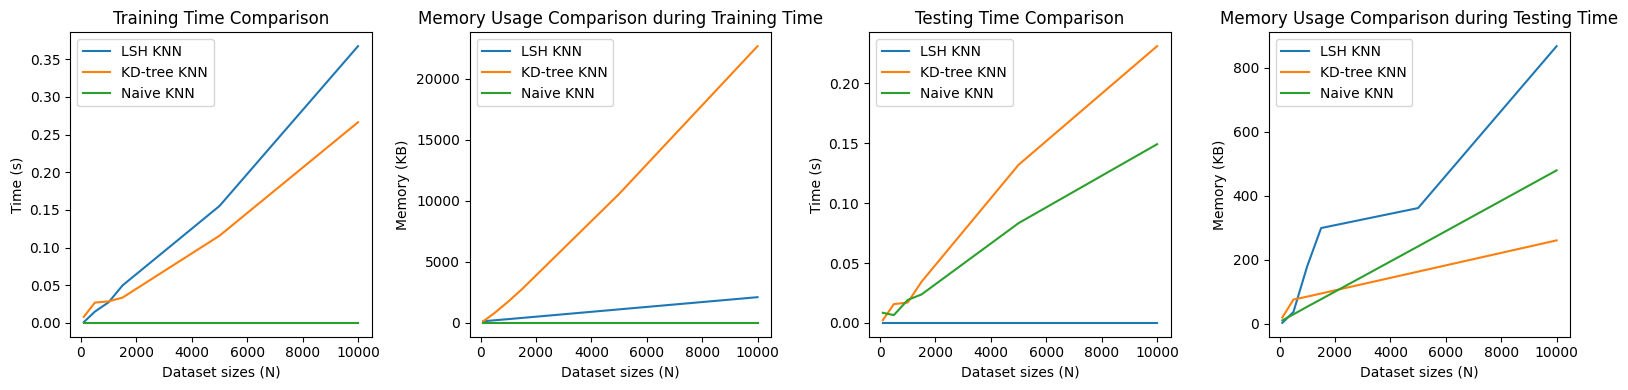

In [166]:
dimensions=20
k=5
dataset_sizes= [100,500,1000,1500,5000,10000]
plot_metrics_N(dataset_sizes, dimensions, k, xlabel="Dataset sizes (N)")

Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbours appx. $KNN$ methods miss out due to their approximate nature. 

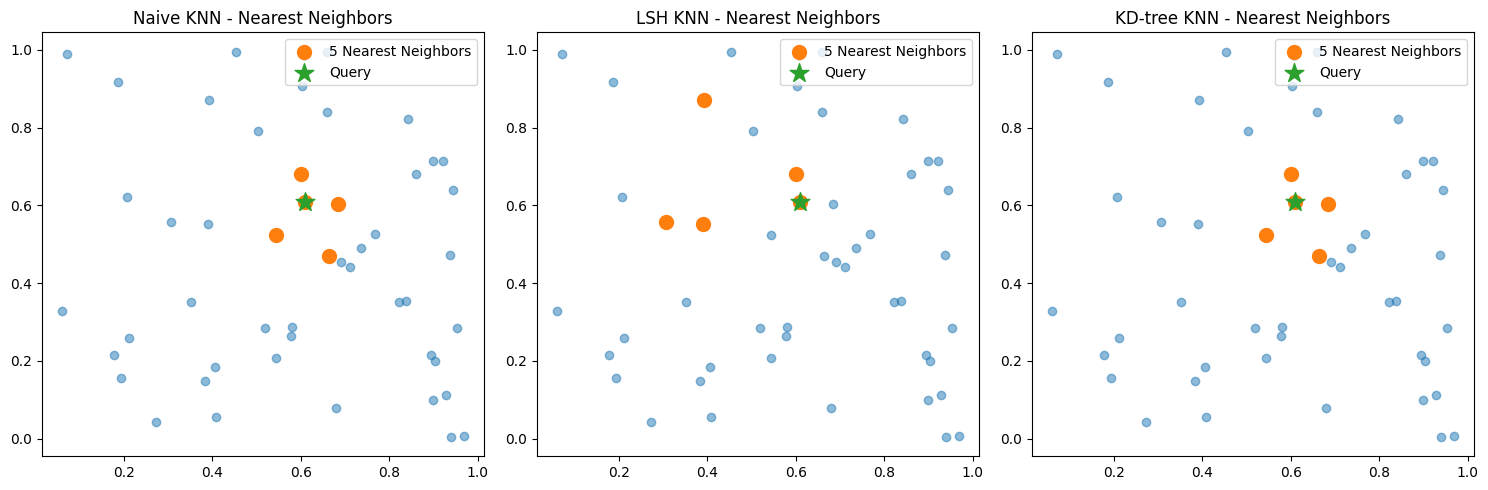

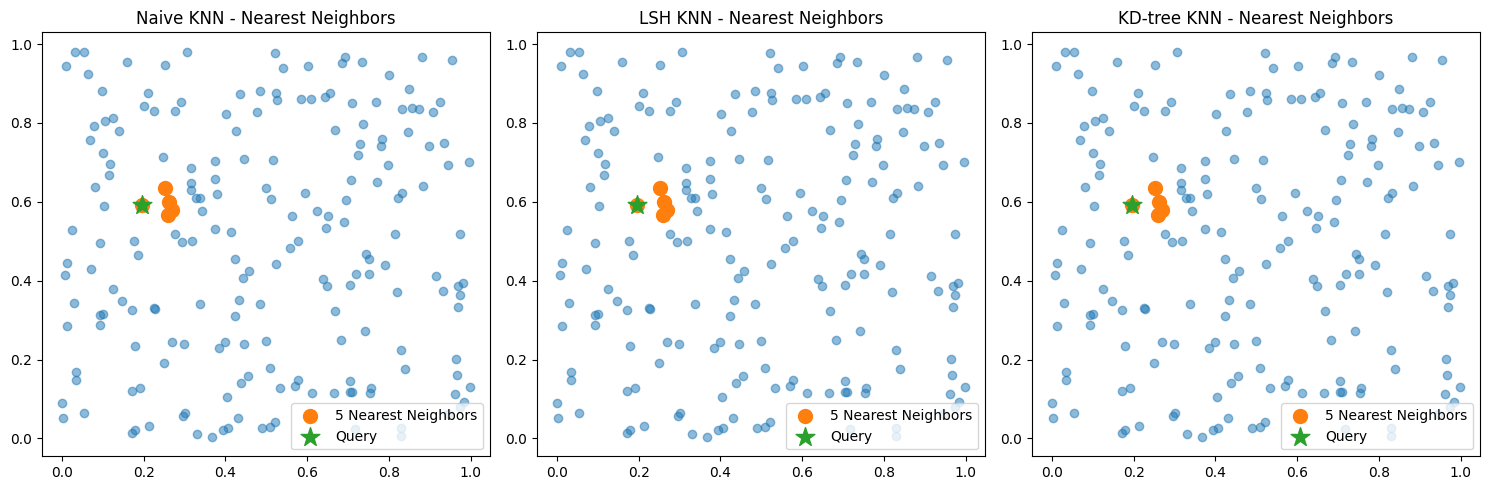

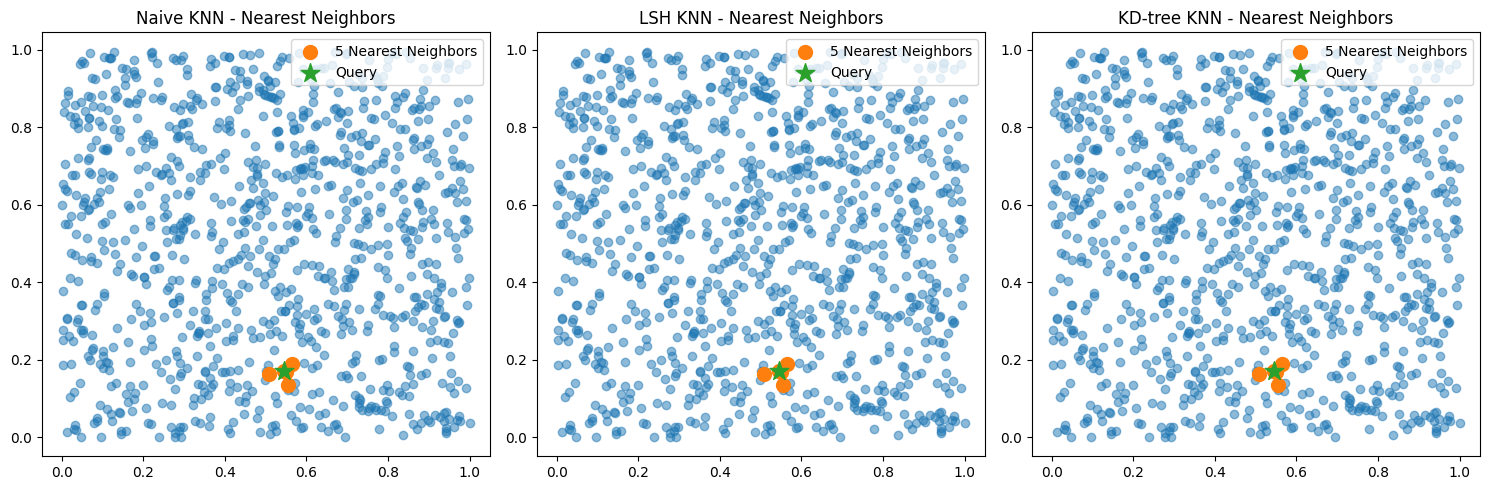

In [176]:
data_sizes = [50, 200,1000]
for data_size in data_sizes:
    dataset = generate_dataset(data_size, 2)
    query = dataset[np.random.randint(len(dataset))]
    y = np.random.randint(2, size = data_size)

    k = 5
    naive_knn = NaiveKNN(k = k)
    naive_knn.fit(dataset,y)    
    naive_neighbors = naive_knn.predict(query)[0]
    
    lsh = LSH(dataset)
    lsh_neighbors = lsh.query(query, k=k)
    
    kdtree = KDTree(dataset)
    kdtree.data = dataset
    kdtree_neighbors = kdtree.query(query, k=k)

    # Plot the data points, query, and neighbors for each method
    methods = ['Naive KNN', 'LSH KNN', 'KD-tree KNN']
    neighbors = [naive_neighbors, lsh_neighbors, kdtree_neighbors]
    trees = [None, None, kdtree]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (ax, method, nn) in enumerate(zip(axs, methods, neighbors)):
        ax.scatter(dataset[:, 0], dataset[:, 1], alpha=0.5)
        ax.scatter(dataset[nn, 0], dataset[nn, 1], s=100, label=f'{k} Nearest Neighbors')
        ax.scatter(query[0], query[1], marker='*', s=200, label='Query')
        ax.legend()
        ax.set_title(f'{method} - Nearest Neighbors')

    plt.tight_layout()
    plt.show() 

Also show the partitions in the 2d space.

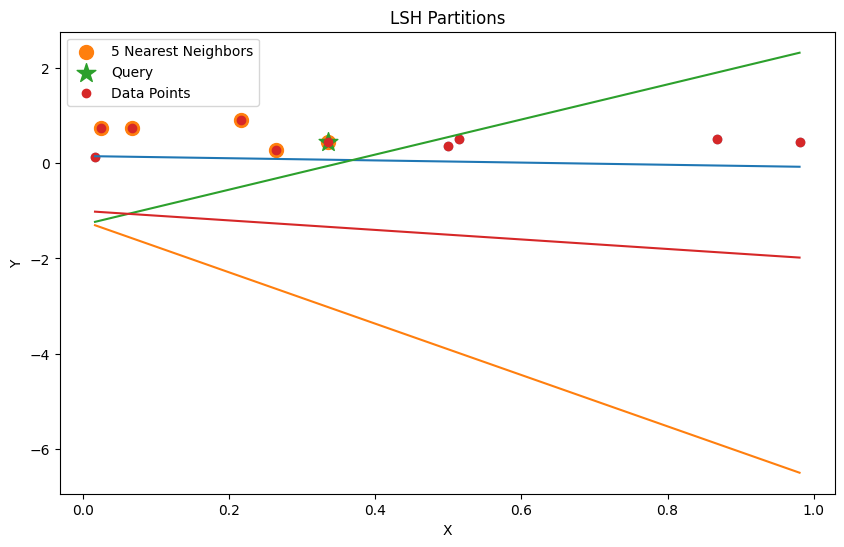

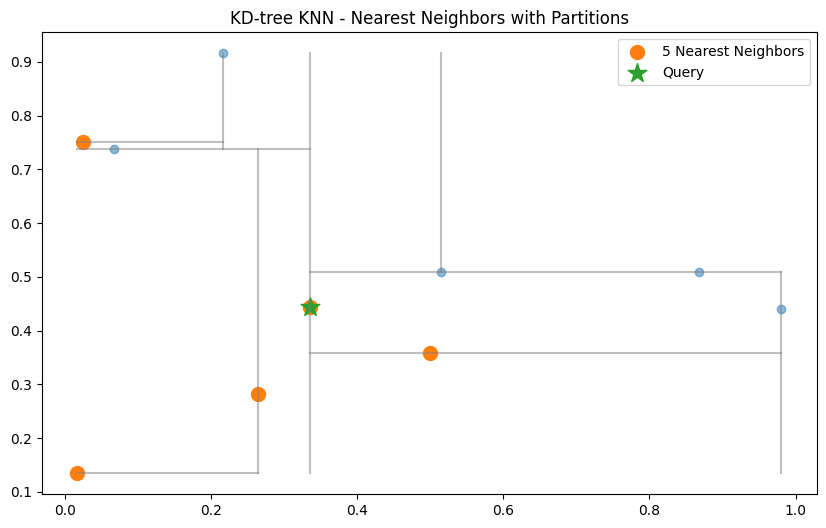

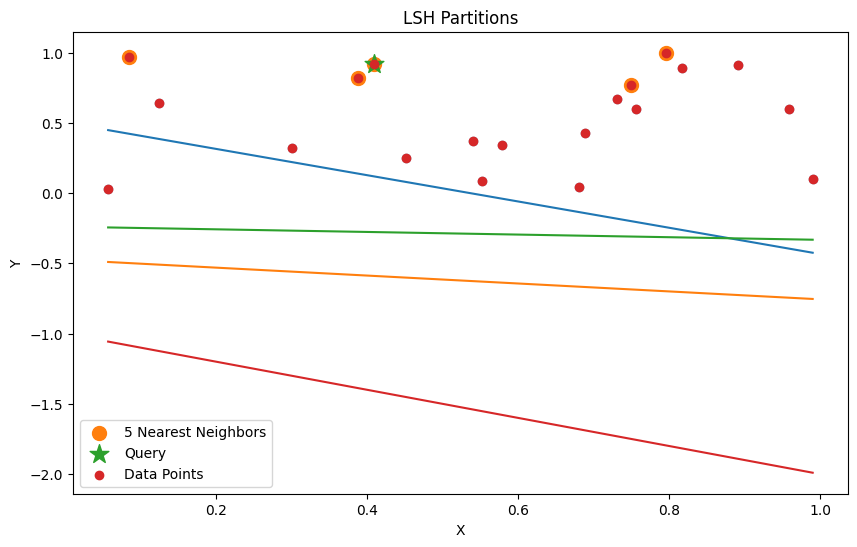

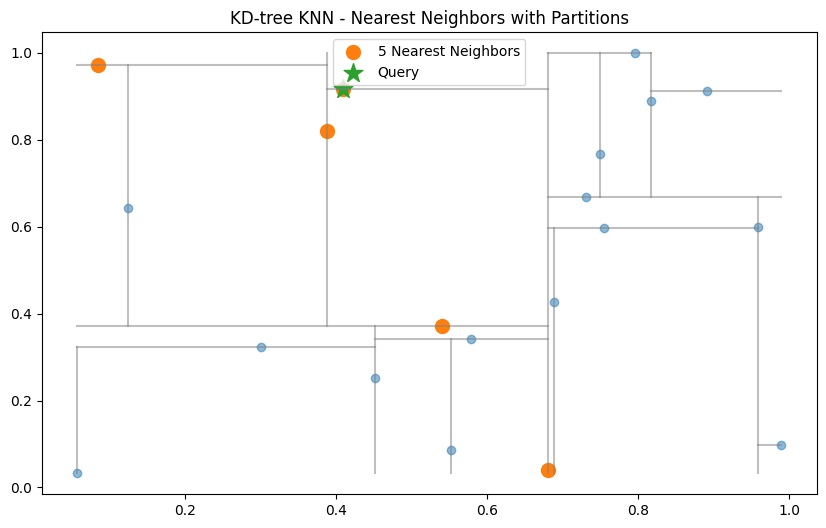

In [125]:
# With partitions
def plot_partitions_kdtree(node, xmin, xmax, ymin, ymax, depth=0):
    if node is None:
        return

    if depth % 2 == 0:
        # Split along x-axis
        plt.plot([node.point[0], node.point[0]], [ymin, ymax], color='gray', linestyle='-', alpha=0.5)
        plot_partitions_kdtree(node.left_child, xmin, node.point[0], ymin, ymax, depth + 1)
        plot_partitions_kdtree(node.right_child, node.point[0], xmax, ymin, ymax, depth + 1)
    else:
        # Split along y-axis
        plt.plot([xmin, xmax], [node.point[1], node.point[1]], color='gray', linestyle='-', alpha=0.5)
        plot_partitions_kdtree(node.left_child, xmin, xmax, ymin, node.point[1], depth + 1)
        plot_partitions_kdtree(node.right_child, xmin, xmax, node.point[1], ymax, depth + 1)

def plot_neighbors_with_partitions(dataset, query, neighbors, method, tree):
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[:, 0], dataset[:, 1], alpha=0.5)
    plt.scatter(dataset[neighbors, 0], dataset[neighbors, 1], s=100, label=f'{len(neighbors)} Nearest Neighbors')
    plt.scatter(query[0], query[1], marker='*', s=200, label='Query')

    # Plot partitions for KD-tree method
    if method == 'KD-tree KNN':
        plot_partitions_kdtree(tree.root, dataset[:, 0].min(), dataset[:, 0].max(), dataset[:, 1].min(), dataset[:, 1].max())
        plt.legend()
        plt.title(f'{method} - Nearest Neighbors with Partitions')
        plt.show()

    elif method=="LSH KNN":
        lsh.plot_partitions()


data_sizes = [10, 20]
for data_size in data_sizes:
    dataset = generate_dataset(data_size, 2)
    query = dataset[np.random.randint(len(dataset))]
    y = np.random.randint(2, size = data_size)

    k = 5
    naive_knn = NaiveKNN(k = k)
    naive_knn.fit(dataset,y)    
    naive_neighbors = naive_knn.predict(query)[0]
    
    lsh = LSH(dataset,num_bits=4)
    lsh_neighbors = lsh.query(query, k=k)
    
    kdtree = KDTree(dataset)
    kdtree.data = dataset
    kdtree_neighbors = kdtree.query(query, k=k)


    # plot_neighbors_with_partitions(dataset, query, naive_neighbors, 'Naive KNN', None)
    plot_neighbors_with_partitions(dataset, query, lsh_neighbors, 'LSH KNN', None)
    plot_neighbors_with_partitions(dataset, query, kdtree_neighbors, 'KD-tree KNN', kdtree)